## Importing libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as gensim_api
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine

## Loading the data

In [27]:
# Load the dataset to see its structure
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

df = pd.read_csv(url_data + 'new_df.csv')

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()

print('Shape of label tensor:', y.shape)
print('Shape of X:', X.shape)
print('Shape of embeddings_GloVe:', embeddings_GloVe.shape)

Shape of label tensor: (12854, 1)
Shape of X: (12854, 20)
Shape of embeddings_GloVe: (22341, 101)


In [28]:
X_df = pd.read_csv(url_data+'new_df.csv')

In [29]:
X_df['y_liberal'] = y_df

In [30]:
# Assuming your DataFrame is named 'df' and the column you want to check is named 'column_name'
empty_rows = X_df['without_stopwords'].isnull()  # Check for empty values in the column

texts = X_df.dropna(subset=['without_stopwords'])['without_stopwords']

In [31]:
texts

0        matter look like language speak wear remember ...
1              biden speech draw million usa tv viewer nan
2              state union watch state union night opinion
3                                    poor people money nan
4                                                  dew nan
                               ...                        
12849    ron paul spirited defense wikileaks free infor...
12850    anarcho capitalism opinion doctrinal system im...
12851    mises wiki wiki project dedicate advancement a...
12852    fireman protection monopoly failed capitalism nan
12853    wikipedia article better write listen writing ...
Name: without_stopwords, Length: 12804, dtype: object

## Processing the text


In [32]:
# Using the tensorflow tokenizer for simplifying our neural network processing

tokenizer = Tokenizer(oov_token='<OOV>') # Hyperparameters = num_words=vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(texts)

#Creating a word index of the words from the tokenizer 
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n\nFirst 10 is listen below:')
print(dict(list(word_index.items())[0:10]))

Found 22340 unique tokens.

First 10 is listen below:
{'<OOV>': 1, 'nan': 2, 'people': 3, 'usa': 4, 'like': 5, 'work': 6, 'right': 7, 'trump': 8, 'think': 9, 'state': 10}


In [33]:
# Creating a dictionary
word_dict = dict((num, val) for (val, num) in word_index.items())

## Exploritary analysis

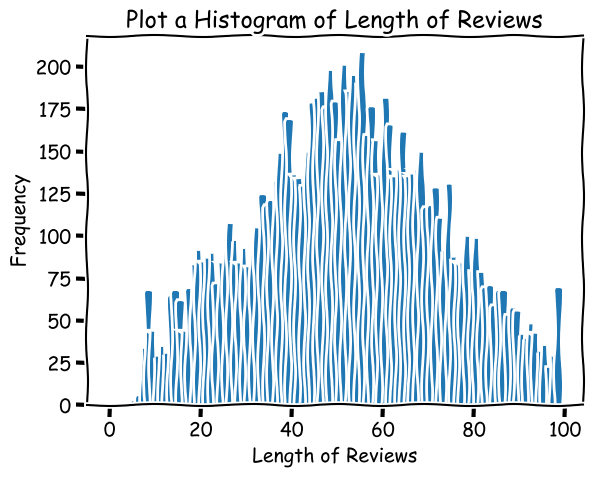

In [34]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

reviews_encoded = []
for review in texts:
    reviews_encoded.append([word_index.get(x) for x in review])

# Plot a Histogram of length of reviews
lengths = [len(x) for x in reviews_encoded]
with plt.xkcd():
    plt.hist(lengths, bins=range(100))
    plt.title('Plot a Histogram of Length of Reviews')
    plt.xlabel('Length of Reviews')
    plt.ylabel('Frequency')  # Add y-label if needed
    plt.show()

In [35]:
all_texts_length = df['All_text'].apply(lambda x: len(x.split()))
# Now, let's analyze the distribution of these sequence lengths
all_texts_length.describe()

count    12854.000000
mean        47.996032
std        183.825637
min          2.000000
25%         10.000000
50%         14.000000
75%         23.000000
max       5719.000000
Name: All_text, dtype: float64

## Hyperparametere  for the embedding

In [36]:
# Defining pre-processing hyperparameters for the networks
max_len = 20
trunc_type = "post"
padding_type = "post"
vocab_size = len(word_index)
# This is fixed.
embedding_dim = 100


In [37]:
# Encoding the sequences from the reddit posts
X_tensorflow = tokenizer.texts_to_sequences(texts)
# Padding the sequences to keep the lengths uniform
X_tensorflow = pad_sequences(X, maxlen=max_len, padding=padding_type, truncating=trunc_type)
# print('Shape of data tensor:', X_tensorflow.shape)

## Visualization of our dataset

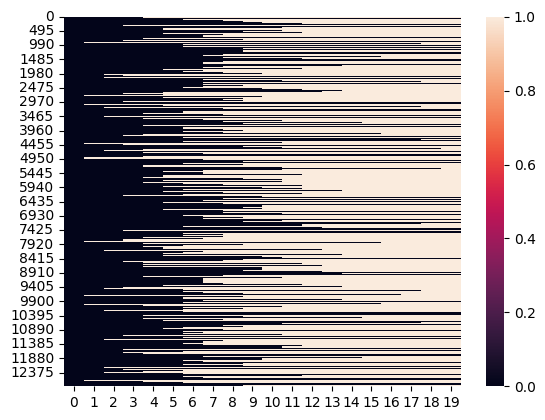

In [38]:
# Heatmap of the word lengths
sns.heatmap(X_tensorflow==0, vmin=0, vmax=1, cbar=True)
plt.show()

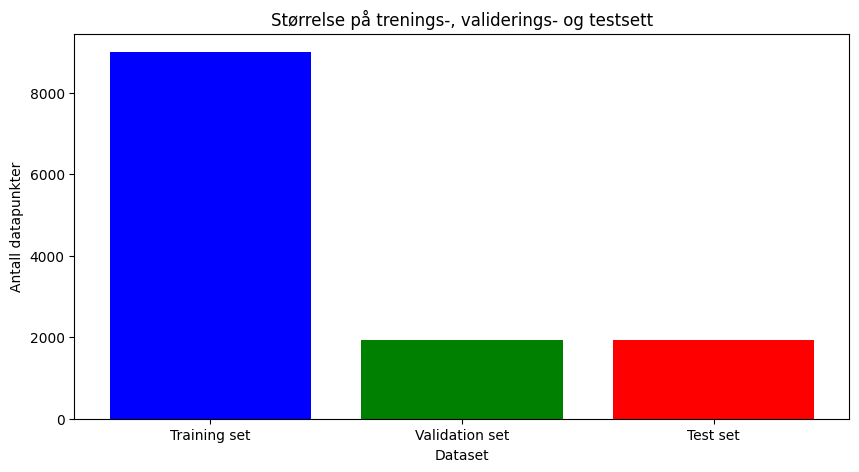

In [39]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Anta at du har størrelsene på datasettene
train_size = len(X_train)
val_size = len(X_val)
test_size = len(X_test)

# Data for visualiseringene
sizes = [train_size, val_size, test_size]
labels = ['Training set', 'Validation set', 'Test set']

# Stolpediagram
plt.figure(figsize=(10, 5))
plt.bar(labels, sizes, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Antall datapunkter')
plt.title('Størrelse på trenings-, validerings- og testsett')
plt.show()

# Creating embeddings

### GloVe

In [40]:
file_path = r"C:\Users\bugat\OneDrive\Bilder\Dokumenter\Downloads\glove.6B.100d.txt"

In [41]:
embeddings_index = dict()
with open(file_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

vocab_size = len(word_index)
embeddings_GloVe = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_GloVe[i] = embedding_vector

print(embeddings_GloVe.shape)

(22341, 100)


In [52]:
embeddings_df = pd.DataFrame(embeddings_GloVe)
embeddings_df.to_csv('embeddings_glove.csv', index=False)

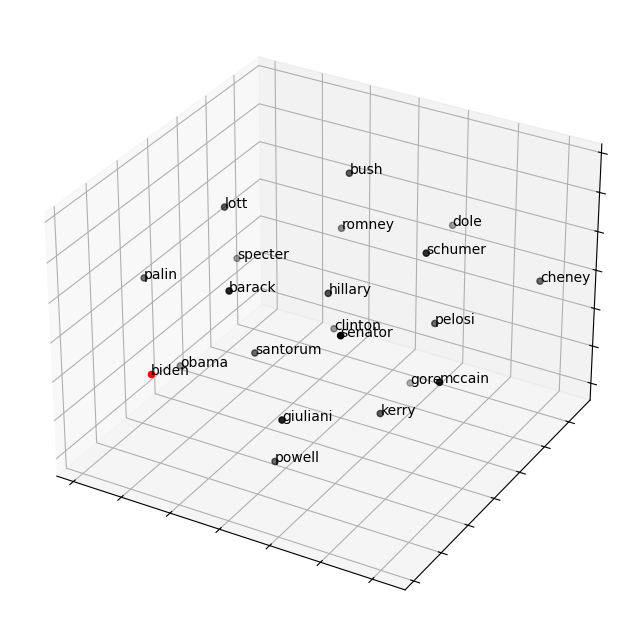

In [43]:
word = "biden"
fig = plt.figure(figsize=(8,10))

# Function to find most similar words, adapted for numpy array embeddings
def find_most_similar(word, embeddings, word_to_index, topn=20):
    index = word_to_index[word]
    word_embedding = embeddings[index].reshape(1, -1)
    # Compute cosine similarity between this word and all others
    similarities = cosine_similarity(word_embedding, embeddings).flatten()
    # Get the indices of the topn most similar words
    most_similar_indices = similarities.argsort()[-topn-1:-1][::-1]
    # Map indices back to words
    index_to_word = {v: k for k, v in word_to_index.items()}
    most_similar_words = [index_to_word[i] for i in most_similar_indices]
    return most_similar_words

# Find most similar words to 'word' in GloVe
tot_words = [word] + find_most_similar(word, embeddings_GloVe, word_index, topn=20)

# Get the embeddings
X = np.array([embeddings_GloVe[word_index[w]] for w in tot_words])

# t-SNE for dimensionality reduction
n_samples = X.shape[0]
perplexity_value = min(40, n_samples - 1)
pca = TSNE(perplexity=perplexity_value, n_components=3, init='pca')
X = pca.fit_transform(X)

# Create DataFrame for plotting
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x", "y", "z"])
dtf_["input"] = 0
dtf_.loc[dtf_.index[0], "input"] = 1

# 3D Plot
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], dtf_[dtf_["input"]==0]['y'], dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], dtf_[dtf_["input"]==1]['y'], dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
for label, row in dtf_[["x", "y", "z"]].iterrows():
    ax.text(row['x'], row['y'], row['z'], s=label)

plt.show()

### Word2Vec

In [44]:
# for word embedding
w2v = gensim_api.load("word2vec-google-news-300")

In [45]:
def print_vec(input_word: str):
    try:
        vec = w2v[input_word]
        print(vec)
    except KeyError:
        print(f"The word {input_word} does not appear in this model")

In [46]:
## create list of lists of unigrams
lst_corpus = []
for string in texts:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1])
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [47]:
## fit w2v
w2v = Word2Vec(lst_corpus,
               vector_size=embedding_dim,
               window=8,
               min_count=1,
               sg=1,
               #sample=1e-3,
               epochs=30)

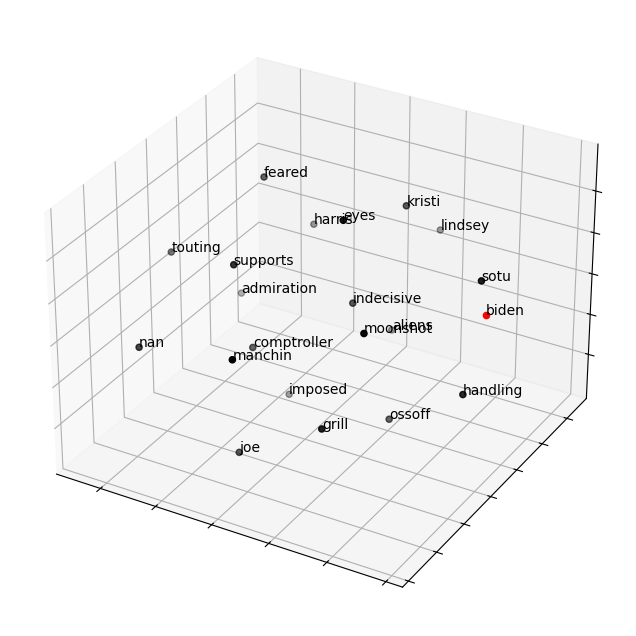

In [48]:
word = "biden"
fig = plt.figure(figsize=(10,8))
## word embedding
tot_words = [word] + [tupla[0] for tupla in w2v.wv.most_similar(word, topn=20)]

X = w2v.wv[tot_words]

# Assuming X is your dataset and it's already defined
n_samples = X.shape[0]

# Make sure perplexity is less than the number of samples
perplexity_value = min(40, n_samples - 1)  # Example adjustment

## pca to reduce dimensionality from 300 to 3
pca = TSNE(perplexity=perplexity_value, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_.loc[dtf_.index[0], "input"] = 1

## plot 3d
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'],
           dtf_[dtf_["input"]==0]['y'],
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'],
           dtf_[dtf_["input"]==1]['y'],
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[],
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

plt.show()

In [49]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings_w2v = np.zeros((len(word_index)+1, embedding_dim))
for word,idx in word_index.items():
    ## update the row with vector
    try:
        embeddings_w2v[idx] =  w2v.wv[idx]
    ## if word not in model then skip and the row stays all 0s
    except:
        embeddings_w2v[idx] = np.zeros(embedding_dim)

word = "london"
print("dic[word]:", word_index[word], "|idx")
print("embeddings[idx]:", embeddings_w2v[word_index[word]].shape,
      "|vector")

dic[word]: 2007 |idx
embeddings[idx]: (100,) |vector
